In [1]:
# Installing necessary packages

!pip install torch torchvision
!pip install light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install fastai --upgrade >> /.tmp

'\n# Installing necessary packages\n\n!pip install torch torchvision\n!pip install light-the-torch >> /.tmp\n!ltt install torch torchvision >> /.tmp\n!pip install fastai --upgrade >> /.tmp\n'

In [2]:
# Importing necessary packages
import pandas as pd
import os
import glob
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
import torch.optim as optim

In [3]:
# Mounting the Google Drive to import all the necessary files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Setting up the DataFrames containing all the necessary images and labels

img_dir = '/content/drive/Shareddrives/BE5740/Dataset/spectrograms_zip/spectrograms'

labels_csv_path = '/content/drive/Shareddrives/BE5740/Dataset/mood/combined_labels.csv'
combined_labels_df = pd.read_csv(labels_csv_path)
combined_labels_df = pd.read_csv(labels_csv_path)
combined_labels_df['image_path'] = combined_labels_df['filename'].apply(lambda x: os.path.join(img_dir, x))
combined_labels_df = combined_labels_df[combined_labels_df['image_path'].apply(os.path.isfile)]

print(combined_labels_df.head())

          filename  label participant_id  \
977  307_seg_1.png      1            307   
978  307_seg_2.png      1            307   
979  307_seg_3.png      1            307   
980  307_seg_4.png      1            307   
981  307_seg_5.png      0            307   

                                            image_path  
977  /content/drive/Shareddrives/BE5740/Dataset/spe...  
978  /content/drive/Shareddrives/BE5740/Dataset/spe...  
979  /content/drive/Shareddrives/BE5740/Dataset/spe...  
980  /content/drive/Shareddrives/BE5740/Dataset/spe...  
981  /content/drive/Shareddrives/BE5740/Dataset/spe...  


In [5]:
# Setting up a labeled dataset for training

class LabeledDataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        self.img_labels = annotations_df
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx]['image_path']
        image = Image.open(img_path).convert('L')  # 'L' mode for grayscale
        label = self.img_labels.iloc[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Creating a transform for our datasets

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


# Transforming the datasets using the transform created
dataset = LabeledDataset(annotations_df=combined_labels_df, transform=transform)

# Setting up the train/test split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creating dataloaders to iterate through the training and testing data
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [7]:
# Creating a function to show a few of the images to ensure our transform of the datasets worked
def show_images(dataloader, num_images=6):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))

    # Set up the figure
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.tight_layout()
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

        # Display the image; images are in grayscale
        plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze removes single-dimensional entries from the shape

    plt.show()


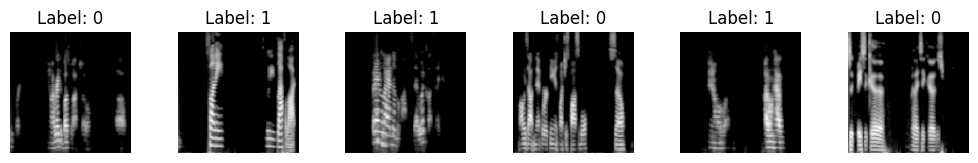

In [8]:
# Showing 6 images as a sanity check
show_images(train_loader, num_images=6)

In [9]:
# Creating a function for our CNN to create our model
class BinaryCNN(nn.Module):
    def __init__(self):
        super(BinaryCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
# Initializing the model
model = BinaryCNN()
model.load_state_dict(torch.load('/content/drive/Shareddrives/BE5740/model_weights_0422_3.pth'))

<All keys matched successfully>

In [11]:
class_counts = [21257, 15702]  # Number of samples for each class
num_samples = sum(class_counts) # Total number of samples
class_weights = [num_samples / class_count for class_count in class_counts] # Creating weights for the model

# Getting all the weights and applying them to the sampler for the training dataloader
sample_weights = [class_weights[label] for _, label in tqdm(train_dataset)]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Creating the dataloader with training data
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# Creating the criterion and optimizer for the model
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if torch.cuda.is_available():
    model.cuda()

# Training loop
num_epochs = 5
loss_values = []

# Training loop for the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        labels = labels.float().unsqueeze(1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_values.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

100%|██████████| 184/184 [00:25<00:00,  7.33it/s]


Epoch 1/5, Loss: 1.6048


100%|██████████| 184/184 [00:23<00:00,  7.75it/s]


Epoch 2/5, Loss: 0.4915


100%|██████████| 184/184 [00:23<00:00,  7.74it/s]


Epoch 3/5, Loss: 0.3238


100%|██████████| 184/184 [00:24<00:00,  7.40it/s]


Epoch 4/5, Loss: 0.1494


100%|██████████| 184/184 [00:24<00:00,  7.53it/s]

Epoch 5/5, Loss: 0.1597


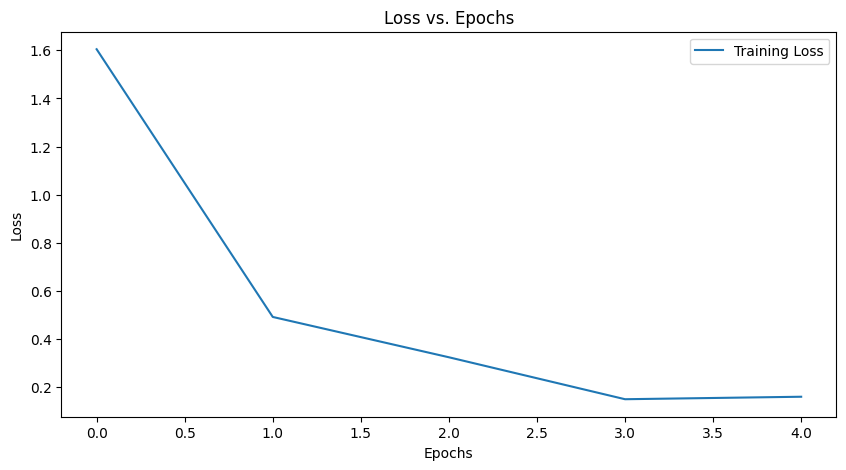

In [12]:
# Plotting the training loss over the number of epochs
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Importing the weights for the model
model_path = '/content/drive/Shareddrives/BE5740/model_weights_0422_3.pth'
model = BinaryCNN()
model.load_state_dict(torch.load(model_path))

# Move model to GPU if available
if torch.cuda.is_available():
    model.cuda()

model.eval()  # Set the model to evaluation mode

BinaryCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [14]:
# Function for testing the model
def test_model(loader, model):
    correct = 0
    total = 0
    predictions = []  # List to store all predictions

    with torch.no_grad():
        for images, labels in tqdm(loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())  # Store predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return np.array(predictions)

In [15]:
# Testing the model
a = test_model(val_loader, model)

100%|██████████| 6/6 [00:10<00:00,  1.67s/it]

Accuracy of the model on the test images: 57.20858895705521%


In [16]:
# Finding the sum to ensure a sensible amount of 1s compare to 0s outputted
sum(a)

0

In [17]:
# Set the path for the test directory and create the dataframes
test_dir = '/content/drive/Shareddrives/BE5740/Dataset/tests/380'

test_csv_path = '/content/drive/Shareddrives/BE5740/Dataset/tests/380_labels.csv'
test_labels_df = pd.read_csv(test_csv_path)
test_labels_df['image_path'] = test_labels_df['filename'].apply(lambda x: os.path.join(test_dir, x))
test_labels_df = test_labels_df[test_labels_df['image_path'].apply(os.path.isfile)]

print(test_labels_df.head())

# Initialize the dataset with the updated transformation
test_dataset = LabeledDataset(annotations_df=test_labels_df, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        filename  label  net_mood  \
0  380_seg_1.png      0    -115.0   
1  380_seg_2.png      1     115.0   
2  380_seg_3.png      1     102.0   
3  380_seg_4.png      0    -102.0   
4  380_seg_5.png      0    -142.0   

                                          image_path  
0  /content/drive/Shareddrives/BE5740/Dataset/tes...  
1  /content/drive/Shareddrives/BE5740/Dataset/tes...  
2  /content/drive/Shareddrives/BE5740/Dataset/tes...  
3  /content/drive/Shareddrives/BE5740/Dataset/tes...  
4  /content/drive/Shareddrives/BE5740/Dataset/tes...  


In [18]:
# Test the model with the testing data
a = test_model(test_loader, model)

100%|██████████| 16/16 [03:21<00:00, 12.61s/it]

Accuracy of the model on the test images: 81.67006109979633%


In [19]:
# View all outputs as a sanity check
print(a)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


In [20]:
# View the ground truth labels to compare to our predictions
print(test_labels_df['label'].to_numpy())

[0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1
 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0]


In [21]:
def calculate_net_mood(df, weights):
    net_mood = sum(df[f'AU{au:02d}_c'] * weight for au, weight in weights.items())
    return net_mood

def process_and_label_images(facs_path, output_spectrogram_path, weights):
    facs = pd.read_csv(facs_path)
    facs['interval'] = (facs['frame'] - 1) // 120
    c_columns = facs.filter(regex='_c$')  # Simplified column filtering
    df = c_columns.groupby(facs['interval']).sum()
    df['net_mood'] = calculate_net_mood(df, weights)


    df['label'] = (df['net_mood'] > 0).astype(int)

    participant_id = facs_path.split('/')[-2]  # Changed to capture directory name
    labels_df = pd.DataFrame({
        'filename': [f"{participant_id}_seg_{i+1}.png" for i in range(len(df))],
        'label': df['label'],
        'net_mood':df['net_mood']
    })

    # Ensure the directory exists before saving
    os.makedirs(output_spectrogram_path, exist_ok=True)
    labels_df.to_csv(os.path.join(output_spectrogram_path, f"{participant_id}_labels.csv"), index=False)

def batch_csv_labeling(root_dir, output_spectrogram_path, weights):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("_Pose_gaze_AUs.csv"):
                facs_path = os.path.join(root, file)
                process_and_label_images(facs_path, output_spectrogram_path, weights)
                print(f"Processed {file}")

In [22]:
weights = {1: -2, 4: -2, 15: -2, 6: 3, 12: 4, 2: 0, 5: 0, 7: -1, 20: 0, 26: -1}

root_directory = '/content/drive/Shareddrives/BE5740/Dataset/All files/300-380/330'
output_directory = '/content/drive/Shareddrives/BE5740/Dataset/tests'
batch_csv_labeling(root_directory, output_directory, weights)

Processed 330_OpenFace2.1.0_Pose_gaze_AUs.csv


In [23]:
def normalize_data(values):
    min_val = min(values)
    max_val = max(values)
    normalized = [(x - min_val) / (max_val - min_val) for x in values]
    return normalized

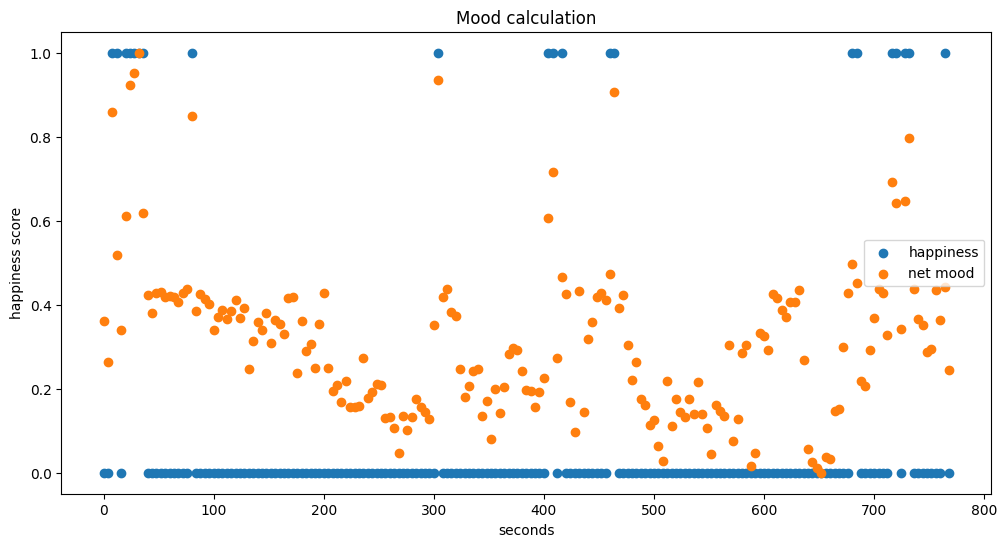

In [24]:
df = pd.read_csv('/content/drive/Shareddrives/BE5740/Dataset/tests/330_labels.csv')
y = df['label'].to_numpy()
z = df['net_mood'].to_numpy()
z = normalize_data(z)
x = np.arange(len(y))*4

plt.figure(figsize=(12,6))
plt.scatter(x,y, label = 'happiness')
plt.scatter(x,z, label='net mood')
plt.title('Mood calculation')

plt.xlabel('seconds')
plt.ylabel('happiness score')
plt.legend()
plt.show()
